## Lightweight Activity Classification With Fused Sensor Data

We present work in progress on activity classification with lightweight ML models, that can be deployed synchronously in embedded applications. We employ off the shelf accelerometer and barometer sensors.

![image](untitled.png)

The visualizations above show general characteristics of the seven target activity classes.

In [16]:
import os
import re
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import skew, iqr
from scipy.fftpack import fft
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler  

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Feature Extraction
We employ ten time domain features and five frequency domain features for each sensor. The feature names are self-explanatory. We window the data into periods of ten seconds with a window shift of two seconds. 

<AxesSubplot:title={'center':'Walking flat surface'}, xlabel='timestamp'>

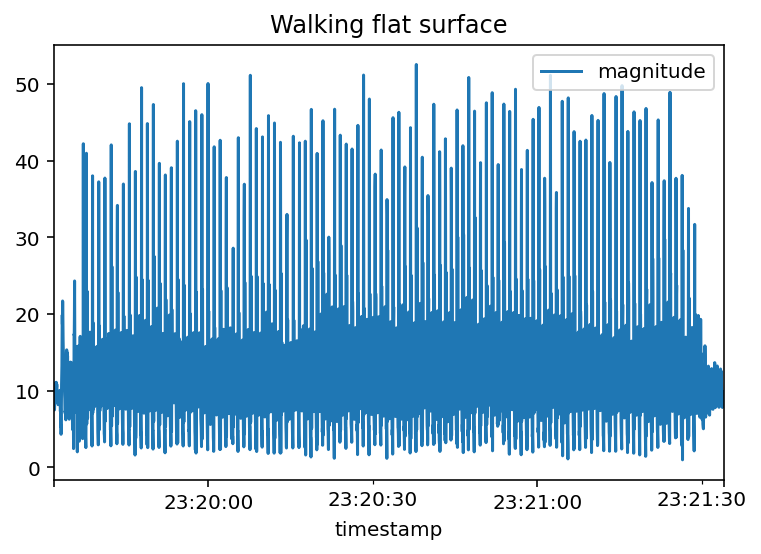

In [7]:
df.plot(title="Walking flat surface")

<AxesSubplot:>

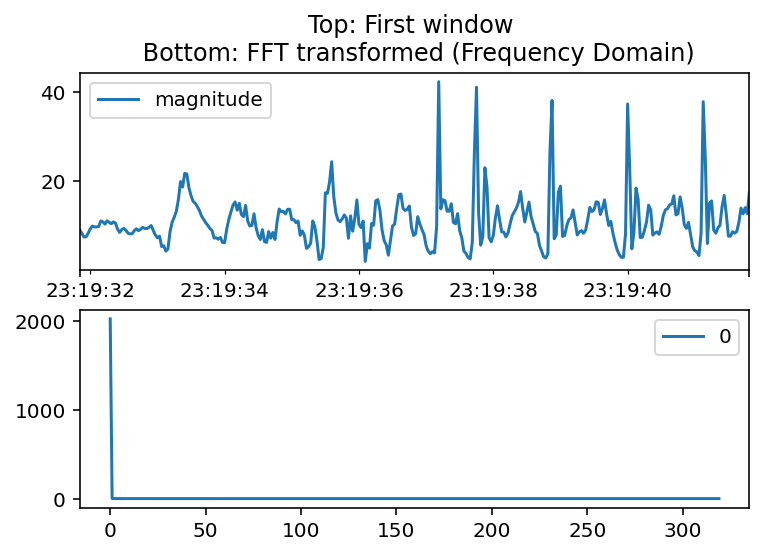

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1)
window.plot(title="Top: First window \n Bottom: FFT transformed (Frequency Domain)",ax=axes[0])
pd.DataFrame(yf).plot(ax=axes[1])

<AxesSubplot:title={'center':'Elevator up'}, xlabel='timestamp'>

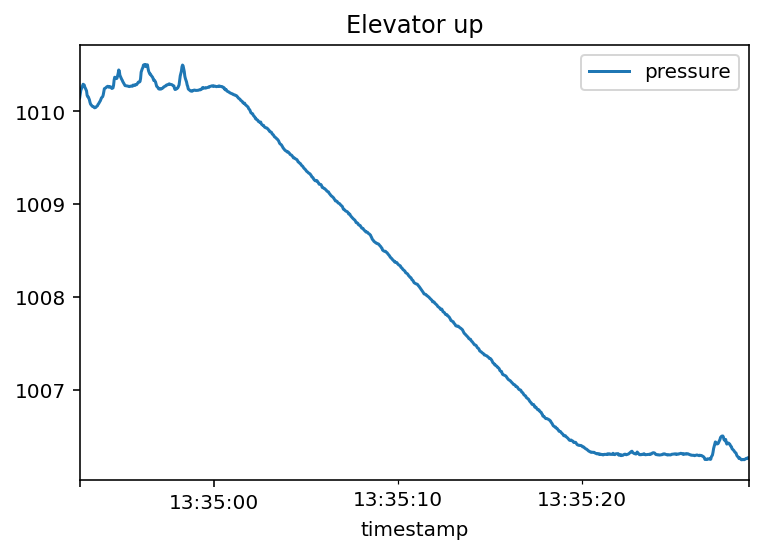

In [25]:
df.plot(title="Elevator up")

<AxesSubplot:>

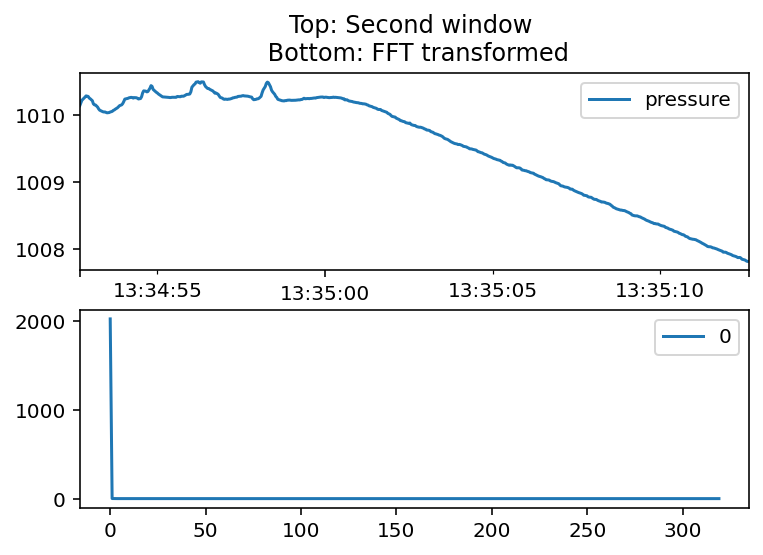

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=1)
window.plot(title="Top: Second window \n Bottom: FFT transformed",ax=axes[0])
pd.DataFrame(yf).plot(ax=axes[1])

<AxesSubplot:title={'center':'Running'}, xlabel='timestamp'>

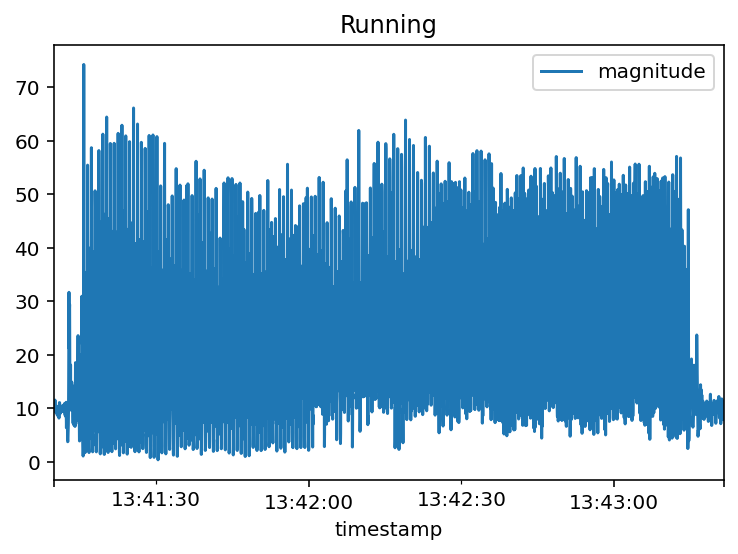

In [35]:
df.plot(title="Running")

<AxesSubplot:>

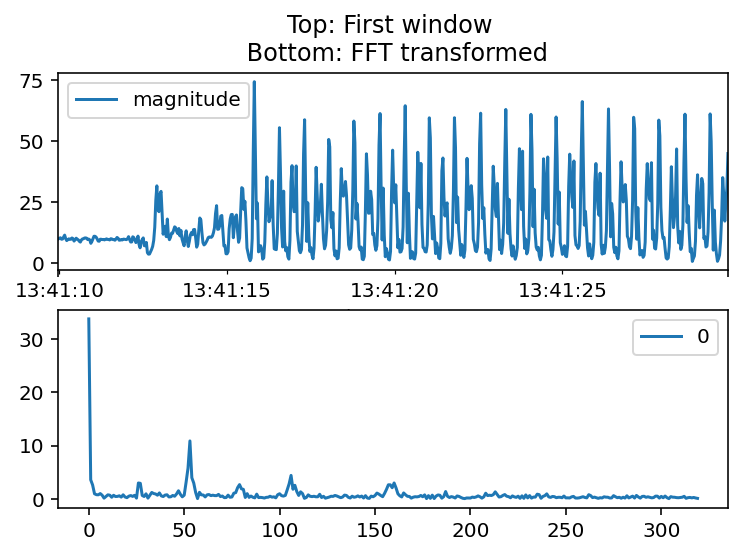

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=1)
window.plot(title="Top: First window \n Bottom: FFT transformed",ax=axes[0])
pd.DataFrame(yf).plot(ax=axes[1])

In [3]:
col_names_accel = ['accel_median', 'accel_std', 'accel_skewness', 'accel_mean_crossing_rate', 'accel_slope',
'accel_num_peaks', 'accel_mean_peak_val', 'accel_mean_peak_distance',
'accel_interquartile_range', 'accel_percentile25', 'accel_spectral_centroid',
'accel_spectral_spread', 'accel_spectral_rolloff_75', 'accel_energy1', 'accel_energy2','activity','id']
col_names_pressure = ['pressure_median', 'pressure_std', 'pressure_skewness', 'pressure_mean_crossing_rate', 'pressure_slope',
'pressure_num_peaks', 'pressure_mean_peak_val', 'pressure_mean_peak_distance',
'pressure_interquartile_range', 'pressure_percentile25', 'pressure_spectral_centroid',
'pressure_spectral_spread', 'pressure_spectral_rolloff_75', 'pressure_energy1', 'pressure_energy2','activity','id']

In [4]:
def extract_features(df, df_type, activity, subject_id):
    '''Windows input data and extracts time and frequency domain features.'''
    if df_type == 'accel':
        col_name = 'magnitude'
    elif df_type == 'pressure':
        col_name = 'pressure'
    lst = []
    #initialize window indices
    left_window = df.index[0]
    right_window = df.index[0] + pd.to_timedelta('10S')
    right_idx = 0
    while right_idx < len(df)-1:
        #find the closest time in the data to our desired window
        left_idx = df.index.get_indexer([left_window], method='nearest')
        right_idx = df.index.get_indexer([right_window], method='nearest')
        window = df.iloc[left_idx[0]:right_idx[0],:]
        
        #calculate time domain features
        mean = window[col_name].mean()
        median = window[col_name].median()
        std = window[col_name].std()
        skewness = skew(window[col_name])
        interquartile_range = iqr(window[col_name])
        percentile25 = np.percentile(window[col_name], 25)
        mean_crossing_rate = ((window[col_name] > mean).astype(int).diff() == 1).sum() / len(window)
        slope, intercept = np.polyfit(np.arange(len(window.index)), window[col_name], 1)
        peaks, _ = find_peaks(window[col_name])
        num_peaks = len(peaks) 
        mean_peak_val = np.mean(window[col_name][peaks])
        mean_peak_distance = np.mean(np.diff(peaks))
        
        # calculate frequency domain features
        y = np.array(window[col_name])
        N = len(y)
        T = 1.0 / 100.0
        yf = np.abs(fft(y))
        yf = 2.0/N * np.abs(yf[:N//2])
        f = np.linspace(0.0, 1.0/(2.0*T), N//2)
        spectral_centroid = np.sum(f * yf) / np.sum(yf)
        spectral_spread = np.sqrt(np.sum(((f - spectral_centroid) ** 2) * yf) / np.sum(yf))
        spectral_rolloff_75 = f[np.where(np.cumsum(yf) >= 0.75 * np.sum(yf))[0][0]]
        energy1 = np.sum(yf[:N//4])
        energy2 = np.sum(yf[N//4:N//2])

        lst.append([median, std, skewness, mean_crossing_rate, slope,
                          num_peaks, mean_peak_val, mean_peak_distance,
                          interquartile_range, percentile25, spectral_centroid, 
                          spectral_spread, spectral_rolloff_75, energy1, energy2, activity, subject_id])
        #move the window
        left_window = df.index[left_idx] + pd.to_timedelta('2S')
        right_window = df.index[left_idx] + pd.to_timedelta('10S')
    return lst
        

In [ ]:
for directory in [x[0] for x in os.walk(os.curdir) if '\\' in x[0]]:
    os.chdir(directory)
    print('Processing directory %s'%(directory))
    subject_id = directory[2:]
    empty_file = False
    for filename in os.listdir():
        if os.path.getsize(filename) < 1:
            empty_file = True
    if not empty_file:
        for filename in os.listdir():
            result = re.search(r"\d{15}-\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}-(.*)-" + subject_id + r"-(\w*).txt", filename)
            if result:
                activity = result.group(1)
                df_type = result.group(2)
                try:
                    if df_type == 'accel':
                        df = pd.read_csv(filename,header=None,index_col=0,names=['timestamp','X','Y','Z'])
                        df.index=pd.to_datetime(df.index,unit='ms')
                        df = df.resample('31.25ms').mean().interpolate(method='time')
                        df['magnitude'] = np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2)
                        df.drop(["X","Y","Z"],axis=1,inplace=True)
                        feature_lst = extract_features(df, df_type, activity, subject_id)
                        accel_df = pd.concat([accel_df,pd.DataFrame(feature_lst, columns = col_names_accel)],axis=0)
                    elif df_type == 'pressure':
                        df = pd.read_csv(filename,header=None,index_col=0,names=['timestamp','pressure'])
                        df.index=pd.to_datetime(df.index,unit='ms')
                        df = df.resample('31.25ms').mean().interpolate(method='time')
                        feature_lst = extract_features(df, df_type, activity, subject_id)
                        pressure_df = pd.concat([pressure_df,pd.DataFrame(feature_lst, columns = col_names_pressure)],axis=0)
                except:
                    print('%s cannot be parsed, skipping.'%(filename))
                    continue
            
    os.chdir('..')

In [116]:
pd.concat([accel_df,pressure_df],axis=1).to_csv('test.csv')

In [330]:
train = pd.read_csv('train.csv',index_col=)

In [117]:
test = pd.read_csv('test.csv',index_col=0)

In [331]:
label = {'Stationary':1, 'Walking-flat-surface':2, 'Walking-up-stairs':3,
       'Walking-down-stairs':4, 'Elevator-up':5, 'Elevator-down':6, 'Running':7}

In [333]:
train['activity'] = train['activity'].replace(label)
test['activity'] = test['activity'].replace(label)

In [127]:
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

In [150]:
train_X = train[train.columns[0:30]]
train_y = train['activity']

In [151]:
test_X = test[test.columns[0:30]]
test_y = test['activity']

In [220]:
target_names = ['Stationary', 'Walking-flat-surface', 'Walking-up-stairs',
       'Walking-down-stairs', 'Elevator-up', 'Elevator-down', 'Running']

## k-nn

In [212]:
neigh = KNeighborsClassifier()

In [213]:
neigh.fit(train_X.fillna(0), train_y)

KNeighborsClassifier()

In [214]:
neigh.score(test_X,test_y)

0.4662576687116564

In [221]:
print(classification_report(test_y, neigh.predict(test_X), target_names=target_names))

                      precision    recall  f1-score   support

          Stationary       0.56      0.85      0.68        59
Walking-flat-surface       0.07      0.08      0.08        59
   Walking-up-stairs       0.00      0.00      0.00        33
 Walking-down-stairs       0.38      0.57      0.46        60
         Elevator-up       0.00      0.00      0.00        30
       Elevator-down       0.17      0.05      0.07        22
             Running       0.95      0.98      0.97        63

            accuracy                           0.47       326
           macro avg       0.31      0.36      0.32       326
        weighted avg       0.38      0.47      0.41       326



In [228]:
multilabel_confusion_matrix(test_y, neigh.predict(test_X))

array([[[228,  39],
        [  9,  50]],

       [[202,  65],
        [ 54,   5]],

       [[288,   5],
        [ 33,   0]],

       [[211,  55],
        [ 26,  34]],

       [[294,   2],
        [ 30,   0]],

       [[299,   5],
        [ 21,   1]],

       [[260,   3],
        [  1,  62]]], dtype=int64)

## Random Forest

In [215]:
clf = RandomForestClassifier()

In [216]:
clf.fit(train_X.fillna(0), train_y)

RandomForestClassifier()

In [229]:
print(classification_report(test_y, clf.predict(test_X), target_names=target_names))

                      precision    recall  f1-score   support

          Stationary       0.95      0.97      0.96        59
Walking-flat-surface       0.12      0.02      0.03        59
   Walking-up-stairs       0.76      0.67      0.71        33
 Walking-down-stairs       0.79      1.00      0.88        60
         Elevator-up       1.00      0.90      0.95        30
       Elevator-down       0.92      1.00      0.96        22
             Running       0.61      0.98      0.75        63

            accuracy                           0.77       326
           macro avg       0.74      0.79      0.75       326
        weighted avg       0.69      0.77      0.71       326



In [230]:
multilabel_confusion_matrix(test_y, clf.predict(test_X))

array([[[264,   3],
        [  2,  57]],

       [[260,   7],
        [ 58,   1]],

       [[286,   7],
        [ 11,  22]],

       [[250,  16],
        [  0,  60]],

       [[296,   0],
        [  3,  27]],

       [[302,   2],
        [  0,  22]],

       [[223,  40],
        [  1,  62]]], dtype=int64)

## Time domain features only

In [251]:
test_X_time = test_X.drop(test_X.columns[10:15],axis=1).drop(test_X.columns[25:30],axis=1)

In [248]:
train_X_time = train_X.drop(train_X.columns[10:15],axis=1).drop(train_X.columns[25:30],axis=1)

In [249]:
clf.fit(train_X_time.fillna(0), train_y)

RandomForestClassifier()

In [252]:
print(classification_report(test_y, clf.predict(test_X_time), target_names=target_names))

                      precision    recall  f1-score   support

          Stationary       0.95      0.97      0.96        59
Walking-flat-surface       0.00      0.00      0.00        59
   Walking-up-stairs       0.56      0.67      0.61        33
 Walking-down-stairs       0.79      0.95      0.86        60
         Elevator-up       1.00      0.87      0.93        30
       Elevator-down       0.88      1.00      0.94        22
             Running       0.66      0.98      0.79        63

            accuracy                           0.75       326
           macro avg       0.69      0.78      0.73       326
        weighted avg       0.65      0.75      0.70       326



In [253]:
multilabel_confusion_matrix(test_y, clf.predict(test_X_time))

array([[[264,   3],
        [  2,  57]],

       [[257,  10],
        [ 59,   0]],

       [[276,  17],
        [ 11,  22]],

       [[251,  15],
        [  3,  57]],

       [[296,   0],
        [  4,  26]],

       [[301,   3],
        [  0,  22]],

       [[231,  32],
        [  1,  62]]], dtype=int64)

## Frequency domain features only

In [254]:
test_X_freq = test_X.drop(test_X.columns[0:10],axis=1).drop(test_X.columns[15:25],axis=1)

In [255]:
train_X_freq = train_X.drop(train_X.columns[0:10],axis=1).drop(train_X.columns[15:25],axis=1)

In [257]:
clf.fit(train_X_freq.fillna(0), train_y)

RandomForestClassifier()

In [258]:
print(classification_report(test_y, clf.predict(test_X_freq), target_names=target_names))

                      precision    recall  f1-score   support

          Stationary       0.95      0.92      0.93        59
Walking-flat-surface       0.08      0.02      0.03        59
   Walking-up-stairs       0.11      0.18      0.13        33
 Walking-down-stairs       0.25      0.37      0.30        60
         Elevator-up       0.28      0.17      0.21        30
       Elevator-down       0.42      0.64      0.51        22
             Running       1.00      0.98      0.99        63

            accuracy                           0.50       326
           macro avg       0.44      0.47      0.44       326
        weighted avg       0.49      0.50      0.49       326



In [259]:
multilabel_confusion_matrix(test_y, clf.predict(test_X_freq))

array([[[264,   3],
        [  5,  54]],

       [[255,  12],
        [ 58,   1]],

       [[243,  50],
        [ 27,   6]],

       [[201,  65],
        [ 38,  22]],

       [[283,  13],
        [ 25,   5]],

       [[285,  19],
        [  8,  14]],

       [[263,   0],
        [  1,  62]]], dtype=int64)

The accuracy only lowers by 2% when removing frequency domain features, but over 20% when removing time domain features.

## LOOCV

In [ ]:
#generate .csv files for each subject
data_dir = 'data_dir'
os.chdir(data_dir)
for directory in [x[0] for x in os.walk(os.curdir) if '\\' in x[0]]:
    accel_df = pd.DataFrame()
    pressure_df = pd.DataFrame()
    os.chdir(directory)
    print('Processing directory %s'%(directory))
    subject_id = directory[2:]
    empty_file = False
    for filename in os.listdir():
        if os.path.getsize(filename) < 1:
            empty_file = True
    if not empty_file:
        for filename in os.listdir():
            result = re.search(r"\d{15}-\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}-(.*)-" + subject_id + r"-(\w*).txt", filename)
            if result:
                activity = result.group(1)
                df_type = result.group(2)
                try:
                    if df_type == 'accel':
                        df = pd.read_csv(filename,header=None,index_col=0,names=['timestamp','X','Y','Z'])
                        df.index=pd.to_datetime(df.index,unit='ms')
                        df = df.resample('31.25ms').mean().interpolate(method='time')
                        df['magnitude'] = np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2)
                        df.drop(["X","Y","Z"],axis=1,inplace=True)
                        feature_lst = extract_features(df, df_type, activity, subject_id)
                        accel_df = pd.concat([accel_df,pd.DataFrame(feature_lst, columns = col_names_accel)],axis=0)
                    elif df_type == 'pressure':
                        df = pd.read_csv(filename,header=None,index_col=0,names=['timestamp','pressure'])
                        df.index=pd.to_datetime(df.index,unit='ms')
                        df = df.resample('31.25ms').mean().interpolate(method='time')
                        feature_lst = extract_features(df, df_type, activity, subject_id)
                        pressure_df = pd.concat([pressure_df,pd.DataFrame(feature_lst, columns = col_names_pressure)],axis=0)
                except:
                    print('%s cannot be parsed, skipping.'%(filename))
                    continue
            
    os.chdir('..')
    accel_df.reset_index(drop=True,inplace=True)
    pressure_df.reset_index(drop=True,inplace=True)
    if (len(accel_df) != len(pressure_df)):
        #windowed timestamps are out of sync, so we ignore this data
        print('Mismatch on %s'%subject_id)
    else: 
        pd.concat([accel_df,pressure_df],axis=1).to_csv('%s.csv'%subject_id)

In [318]:
#leave one out CV
file_list = []
y_true = pd.DataFrame()
y_pred = pd.DataFrame()
data_dir = 'data_dir'
os.chdir(data_dir)
for filename in os.listdir():
    if filename.endswith('csv'):
        file_list.append(filename)
for x in range(len(file_list)):
    train_X = pd.DataFrame()
    train_y = pd.DataFrame()
    test = file_list[x]
    train = [y for y in file_list if y != test]
    for file in train:
        df = pd.read_csv(file,index_col=0)
        train_X = pd.concat([train_X,df[df.columns[0:30]]],axis=0)
        train_y = pd.concat([train_y,df['activity'].replace(label)],axis=0,ignore_index=True)
    df = pd.read_csv(test,index_col=0)
    test_X = df[df.columns[0:30]]
    test_y = df['activity'].replace(label)
    clf.fit(train_X.fillna(0), train_y)
    y_true.append(test_y)
    y_true = pd.concat([y_true,test_y],axis=0,ignore_index=True)
    y_pred = pd.concat([y_pred,pd.Series(clf.predict(test_X.fillna(0)))],axis=0,ignore_index=True)

In [325]:
print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

          Stationary       0.90      0.98      0.94       434
Walking-flat-surface       0.92      0.78      0.84       397
   Walking-up-stairs       0.82      0.83      0.83       120
 Walking-down-stairs       0.83      0.83      0.83       196
         Elevator-up       0.93      0.92      0.92        99
       Elevator-down       0.93      0.94      0.94        85
             Running       0.89      0.98      0.93       197

            accuracy                           0.89      1528
           macro avg       0.89      0.89      0.89      1528
        weighted avg       0.89      0.89      0.89      1528



In [326]:
multilabel_confusion_matrix(y_true, y_pred)

array([[[1047,   47],
        [  10,  424]],

       [[1104,   27],
        [  87,  310]],

       [[1386,   22],
        [  20,  100]],

       [[1299,   33],
        [  33,  163]],

       [[1422,    7],
        [   8,   91]],

       [[1437,    6],
        [   5,   80]],

       [[1306,   25],
        [   4,  193]]], dtype=int64)

## LSTM

In [525]:
scaler = StandardScaler()  

In [544]:
x_train = scaler.fit_transform(train_X.fillna(0)).reshape((train_X.to_numpy().shape[0], train_X.to_numpy().shape[1], 1))
x_test = scaler.fit_transform(test_X.fillna(0)).reshape((test_X.to_numpy().shape[0], test_X.to_numpy().shape[1], 1))

In [585]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(30,1))
)
model.add(layers.LSTM(32))
model.add(layers.Dense(64))

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy","accuracy"],
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

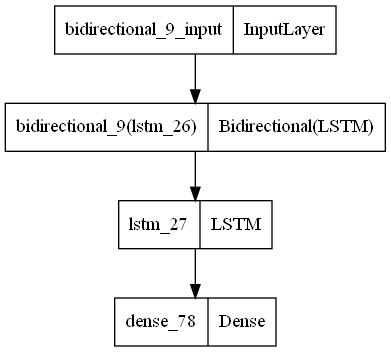

In [590]:
keras.utils.plot_model(model)

In [589]:
model.fit(
    x_train,
    y_train.reshape(-1,1),
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/200
27/27 [==============================] - 0s 17ms/step - loss: 1.1602 - sparse_categorical_accuracy: 0.6498 - accuracy: 0.6498 - val_loss: 1.0923 - val_sparse_categorical_accuracy: 0.7186 - val_accuracy: 0.7186
Epoch 2/200
27/27 [==============================] - 0s 9ms/step - loss: 1.1333 - sparse_categorical_accuracy: 0.6562 - accuracy: 0.6562 - val_loss: 1.0642 - val_sparse_categorical_accuracy: 0.7535 - val_accuracy: 0.7535
Epoch 3/200
27/27 [==============================] - 0s 9ms/step - loss: 1.0939 - sparse_categorical_accuracy: 0.6638 - accuracy: 0.6638 - val_loss: 1.0944 - val_sparse_categorical_accuracy: 0.7628 - val_accuracy: 0.7628
Epoch 4/200
27/27 [==============================] - 0s 9ms/step - loss: 1.0930 - sparse_categorical_accuracy: 0.6661 - accuracy: 0.6661 - val_loss: 1.1678 - val_sparse_categorical_accuracy: 0.7442 - val_accuracy: 0.7442
Epoch 5/200
27/27 [==============================] - 0s 9ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.65

Our bidirectional LSTM model achieves 78% validation accuracy. This is comparable to the Random Forest Classifier.

## Sensor in hand, instead of pocket

In [ ]:
data_dir = '\\inhand'
os.chdir(data_dir)
accel_df = pd.DataFrame()
pressure_df = pd.DataFrame()

for directory in [x[0] for x in os.walk(os.curdir) if '\\' in x[0]]:
    os.chdir(directory)
    print('Processing directory %s'%(directory))
    subject_id = directory[2:]
    empty_file = False
    for filename in os.listdir():
        if os.path.getsize(filename) < 1:
            empty_file = True
    if not empty_file:
        for filename in os.listdir():
            result = re.search(r"\d{15}-\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}-(.*)-" + subject_id + r"-(\w*).txt", filename)
            if result:
                activity = result.group(1)
                df_type = result.group(2)
                try:
                    if df_type == 'accel':
                        df = pd.read_csv(filename,header=None,index_col=0,names=['timestamp','X','Y','Z'])
                        df.index=pd.to_datetime(df.index,unit='ms')
                        df = df.resample('31.25ms').mean().interpolate(method='time')
                        df['magnitude'] = np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2)
                        df.drop(["X","Y","Z"],axis=1,inplace=True)
                        feature_lst = extract_features(df, df_type, activity, subject_id)
                        accel_df = pd.concat([accel_df,pd.DataFrame(feature_lst, columns = col_names_accel)],axis=0)
                    elif df_type == 'pressure':
                        df = pd.read_csv(filename,header=None,index_col=0,names=['timestamp','pressure'])
                        df.index=pd.to_datetime(df.index,unit='ms')
                        df = df.resample('31.25ms').mean().interpolate(method='time')
                        feature_lst = extract_features(df, df_type, activity, subject_id)
                        pressure_df = pd.concat([pressure_df,pd.DataFrame(feature_lst, columns = col_names_pressure)],axis=0)
                except:
                    print('%s cannot be parsed, skipping.'%(filename))
                    continue
            
    os.chdir('..')

In [398]:
test_X = pd.concat([accel_df,pressure_df],axis=1).drop(['id','activity'],axis=1)

In [399]:
test_y = accel_df['activity'].replace(label)

In [400]:
train['activity'] = train['activity'].replace(label)

In [348]:
clf.fit(train_X.fillna(0), train_y)

RandomForestClassifier()

In [24]:
print(classification_report(test_y, clf.predict(test_X), target_names=target_names))

                      precision    recall  f1-score   support

          Stationary       0.98      0.97      0.97        60
Walking-flat-surface       0.66      0.48      0.56        56
   Walking-up-stairs       0.64      0.82      0.72        55
 Walking-down-stairs       0.89      0.93      0.91        55
         Elevator-up       1.00      0.96      0.98        25
       Elevator-down       0.92      1.00      0.96        23
             Running       1.00      0.96      0.98        55

            accuracy                           0.85       329
           macro avg       0.87      0.87      0.87       329
        weighted avg       0.86      0.85      0.85       329



The in hand performance is overall 8% higher than the in pocket performance. There is likely more movement in the pocket, while it would be held relatively stably in the hand.